In [ ]:
import os
from PIL import Image
import numpy as np
# import keras
from tensorflow import keras 
# import cv
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions


vggModel = VGG16(weights='imagenet', include_top=False)
#vggModel1 = VGG19(weights='imagenet', include_top=False)
#resModel = ResNet50(weights='imagenet',include_top=False)
#xceptionModel = Xception(weights='imagenet',include_top=False)
#MobModel = MobileNetV2(weights='imagenet',include_top=False)
#InceModel = InceptionV3(weights='imagenet',include_top=False)
#DenseModel = DenseNet121(weights='imagenet',include_top=False)
% pyplot inline

model = vggModel

X = []
Y = []
classCount = 0

base_path='./Dataset/IQ-OTHNCCD'
a=0
source_path=base_path
for child in os.listdir(source_path):
    classCount +=1
    print(child)
    c=0
    sub_path = os.path.join(source_path, child)
    if os.path.isdir(sub_path):
        a+=1
        for data_file in os.listdir(sub_path):
            Qry = Image.open(os.path.join(sub_path, data_file))
            Qry = Qry.convert("RGB")
            Qry_ = np.array(Qry.resize((224,224)))
            Qry = Qry_.reshape([-1,224,224,3])
            feature=(model.predict([Qry])).flatten()
            X.append(feature)
            Y.append(child)


print('No of classes : ',classCount)


ModuleNotFoundError: No module named 'PIL'

In [2]:
print(np.shape(X))
print(np.shape(Y))


(1098, 25088)
(1098,)


In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Model
from numpy import expand_dims

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ASUS\new\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['square']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


1/1 [==============================] - 1s 626ms/step


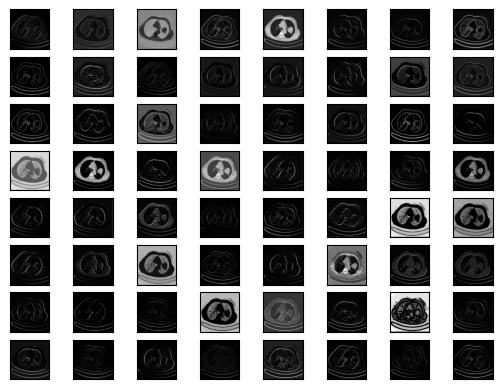

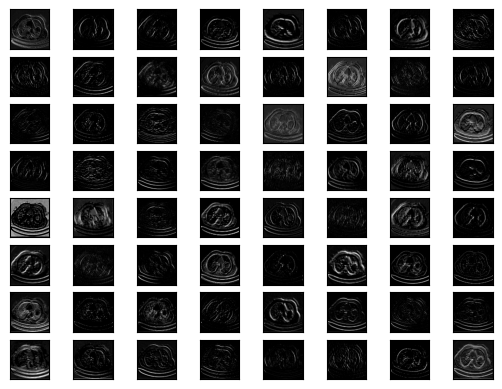

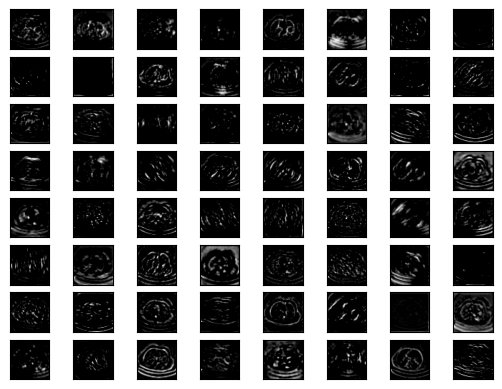

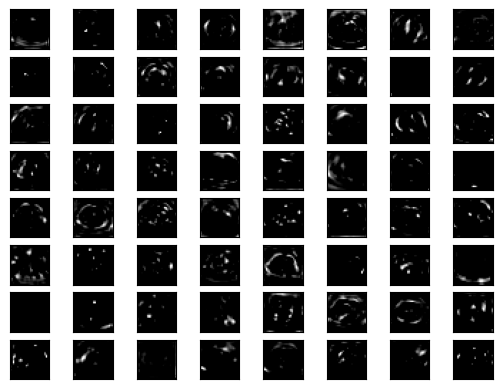

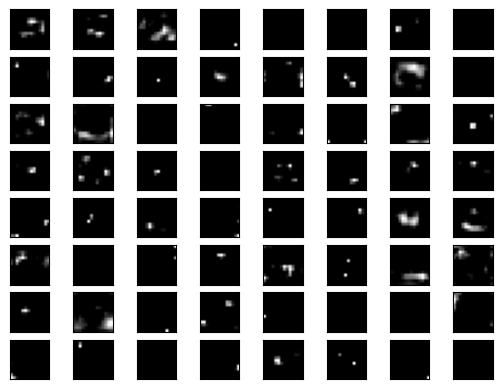

In [7]:
%pylab inline
#load the model
model = vggModel
#redefine model to output right after the first hidden layer 
ixs = [2,5,9,13,17]

outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs,outputs=outputs)
#load the image with the required shape
img = load_img('Malignantcase.jpg',target_size=(224,224))
#Convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img,axis=0)
#prepare the image(eg:scale pixel values for VGG)
img = preprocess_input(img)
#get feature maps for first hidden layer
feature_maps = model.predict(img)
#plot the outputfrom each block
square = 8
for fmap in feature_maps:
    #plot all 64 maps in an 8x8 square
    ix =1
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square,square,ix)
            ax.set_xticks([])
            ax.set_yticks([])
            #plot filter channel in grayscale
            pyplot.imshow(fmap[0,:,:,ix-1],cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()
            


In [8]:
#ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=80,criterion='gini')
clf = clf.fit(X, Y)
model_fet = SelectFromModel(clf, prefit=True)
X = model_fet.transform(X)

print(np.shape(X))
print(np.shape(Y))

(1098, 4374)
(1098,)


In [44]:
# implement MLP
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
labelBinarizer = LabelEncoder()
y = labelBinarizer.fit_transform(Y)
        
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), 
                                                    test_size=0.2, random_state=15)

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))


import tensorflow as tf
from keras.layers import Activation, Dropout
from tensorflow.python.keras import layers
from tensorflow.python.keras import models


dnnModel=models.Sequential()

dnnModel.add(layers.Dense(100,activation="relu",input_shape=(np.shape(X)[1],)))
dnnModel.add(layers.Dense(70,activation="relu"))
#dnnModel.add(layers.Dense(50,activation="relu"))
#dnnModel.add(layers.Dense(20,activation="relu"))
#dnnModel.add(layers.Dense(10,activation="relu"))
dnnModel.add(layers.Dense(classCount,activation="softmax"))
dnnModel.summary()

dnnModel.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

tbCallBack=tf.keras.callbacks.TensorBoard(log_dir='Graph',histogram_freq=0,write_graph=True,write_images=True)

history1=dnnModel.fit(X_train,y_train,validation_split=0.2,epochs=15,batch_size=32,callbacks=[tbCallBack])
,
testloss, testAccuracy=dnnModel.evaluate(X_test,y_test)

# print(testAccuracy)

dnnModel.save_weights('my_checkpoint')

#dnnModel.load_weights('my_checkpoint')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 100)               437500    
_________________________________________________________________
dense_51 (Dense)             (None, 70)                7070      
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 213       
Total params: 444,783
Trainable params: 444,783
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
22/22 [==============================] - 1s 17ms/step - loss: 4.4183 - accuracy: 0.7635 - val_loss: 1.4912 - val_accuracy: 0.8920
Epoch 2/15
22/22 [==============================] - 0s 6ms/step - loss: 0.2678 - accuracy: 0.9573 - val_loss: 2.3321 - val_accuracy: 0.8920
Epoch 3/15
22/22 [==============================] - 0s 6ms/step - loss: 0.3291 - accuracy: 0.955

In [45]:
print(testAccuracy)
y_pred = dnnModel.predict_classes(X_test)
y_pred = [[i] for i in y_pred]
y_pred=np.array(y_pred).astype("float32")

from sklearn.metrics import classification_report as cf
print()
report = cf(np.argmax(y_test,axis=1), y_pred)

print(report)

0.9909090995788574

              precision    recall  f1-score   support

         0.0       1.00      0.12      0.21       220
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0

    accuracy                           0.12       220
   macro avg       0.33      0.04      0.07       220
weighted avg       1.00      0.12      0.21       220



C:\Users\ASUS\new\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:454: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\ASUS\new\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\new\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are

In [46]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant', 'Normal']))


Accuracy: 0.99

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.98
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99

Classification Report

              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        26
   Malignant       1.00      1.00      1.00       119
      Normal       0.99      0.99      0.99        75

    accuracy                           0.99       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.99      0.99      0.99       220



<Figure size 800x800 with 0 Axes>

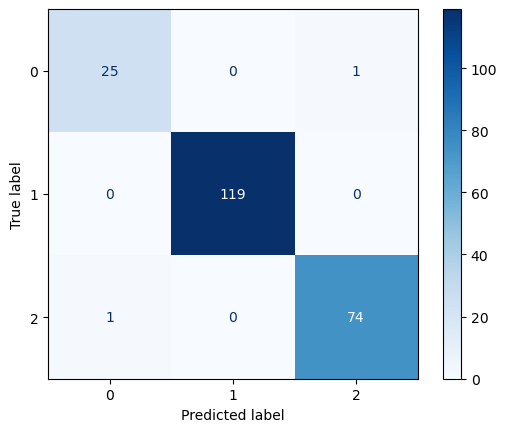

In [47]:

# Calculate the confusion matrix using sklearn.metrics  for the classifier MLP
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)  # shape=(12, 12)
labels = ['Benign Cases', 'Malignant Cases','Normal']

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

figure = plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.show()


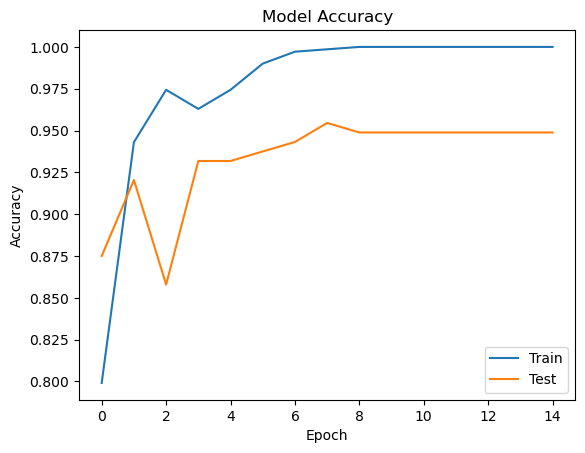

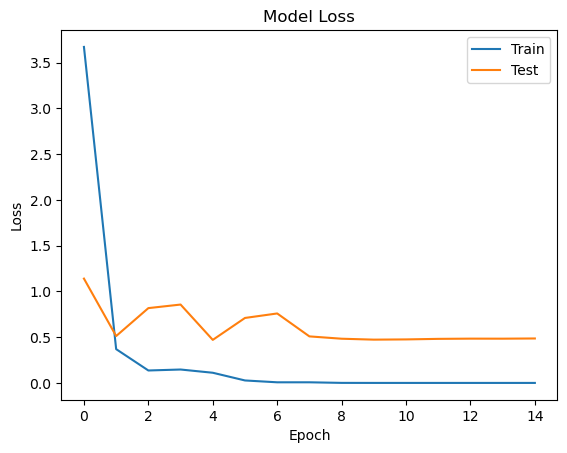

In [105]:
# summarize history for accuracy 
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [48]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [49]:
(TPR,FPR,TNR,FNR)=perf_measure(y_test, y_pred)
# Overall accuracy
print("true positive rate : ",TPR)
print("true negative rate : ",TNR)
print("false positive rate : ",FPR)

true positive rate :  119
true negative rate :  25
false positive rate :  0


C:\Users\ASUS\new\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:429: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


ROC AUC score: 0.9996701671114584


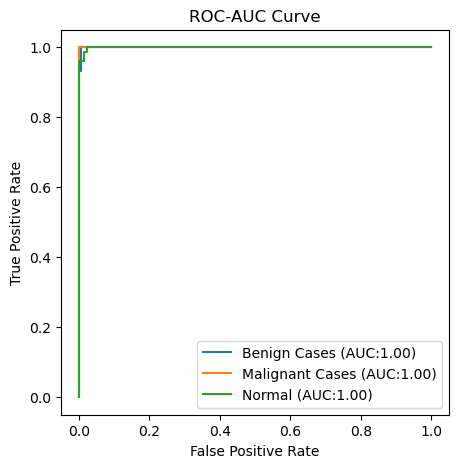

In [50]:

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
labelBinarizer = LabelBinarizer()
y = labelBinarizer.fit_transform(Y)
        
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), 
                                                    test_size=0.2, random_state=42)
probas = dnnModel.predict_proba(X_test)
target= ['Benign Cases', 'Malignant Cases','Normal']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    #c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, probas))

c_ax.legend()
c_ax.set_title('ROC-AUC Curve')
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

0.9863636363636363
                 precision    recall  f1-score   support

   Benign cases       0.91      0.95      0.93        22
Malignant cases       1.00      1.00      1.00       120
   Normal cases       0.99      0.97      0.98        78

       accuracy                           0.99       220
      macro avg       0.97      0.98      0.97       220
   weighted avg       0.99      0.99      0.99       220



C:\Users\ASUS\new\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Figure size 800x800 with 0 Axes>

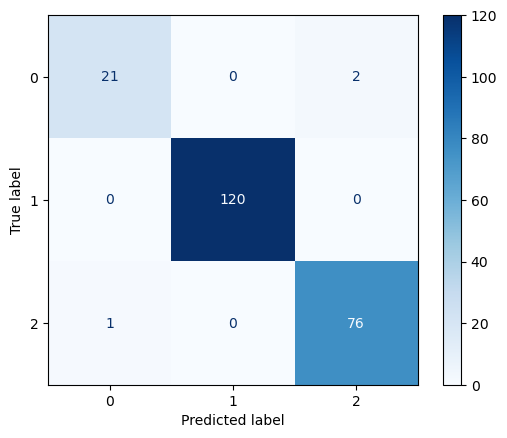

In [52]:
# implement SVC Classifier 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split( np.array(X), np.array(Y),
                                                     test_size=0.20)
                                         

clf = LinearSVC(random_state=0, tol=1e-5,)
clf.fit(X_train, y_train)

y_pred_SVC = clf.predict(X_test)

# get the accuracy
print(accuracy_score(y_test, y_pred_SVC))
accuracy_score(y_pred_SVC,y_test)
print(classification_report(y_pred_SVC,y_test))

# Calculate the confusion matrix using sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_SVC)  # shape=(12, 12)
labels = ['Benign Cases', 'Malignant Cases','Normal']

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

figure = plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.show()



0.9590909090909091
                 precision    recall  f1-score   support

   Benign cases       0.70      1.00      0.82        16
Malignant cases       1.00      0.98      0.99       122
   Normal cases       0.97      0.91      0.94        82

       accuracy                           0.96       220
      macro avg       0.89      0.97      0.92       220
   weighted avg       0.97      0.96      0.96       220



<Figure size 800x800 with 0 Axes>

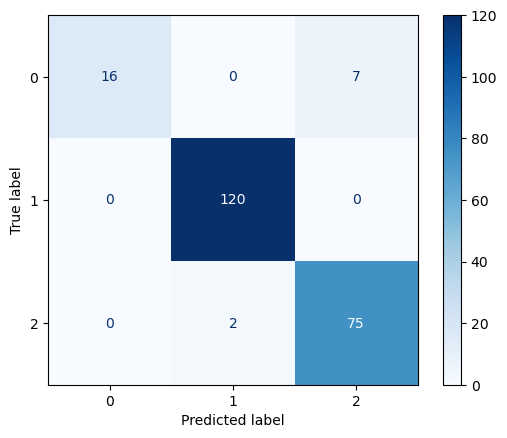

In [53]:
# import Random Forest classifier

from sklearn.ensemble import RandomForestClassifier
# instantiate the classifier 

rfc = RandomForestClassifier(random_state=0,n_estimators=50)
# fit the model

rfc.fit(X_train, y_train)

# Predict the Test set results

y_pred_RF = rfc.predict(X_test)
# get the accuracy
print(accuracy_score(y_test, y_pred_RF))

accuracy_score(y_pred_RF,y_test)
print(classification_report(y_pred_RF,y_test))

# Calculate the confusion matrix using sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_RF)  # shape=(12, 12)
labels = ['Benign Cases', 'Malignant Cases','Normal']

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

figure = plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.show()



0.9318181818181818
                 precision    recall  f1-score   support

   Benign cases       0.52      0.80      0.63        15
Malignant cases       0.99      1.00      1.00       119
   Normal cases       0.96      0.86      0.91        86

       accuracy                           0.93       220
      macro avg       0.82      0.89      0.85       220
   weighted avg       0.95      0.93      0.94       220



<Figure size 800x800 with 0 Axes>

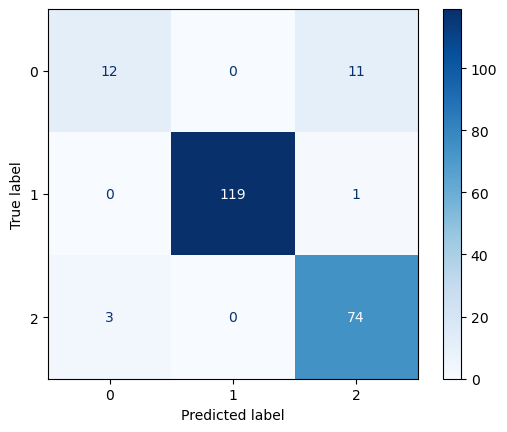

In [57]:
#implement KNN
from sklearn.neighbors import KNeighborsClassifier
#instantiating it to create a KNN model:

knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)
y_pred_knn=knn.predict(X_test)
y_pred_knn
# get the accuracy
print(accuracy_score(y_test, y_pred_knn))
accuracy_score(y_pred_knn,y_test)
print(classification_report(y_pred_knn,y_test))
# Calculate the confusion matrix using sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_knn)  # shape=(12, 12)
labels = ['Benign Cases', 'Malignant Cases','Normal']

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

figure = plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.show()

0.9363636363636364
                 precision    recall  f1-score   support

   Benign cases       0.83      0.90      0.86        21
Malignant cases       0.95      0.96      0.95       119
   Normal cases       0.95      0.91      0.93        80

       accuracy                           0.94       220
      macro avg       0.91      0.93      0.92       220
   weighted avg       0.94      0.94      0.94       220



<Figure size 800x800 with 0 Axes>

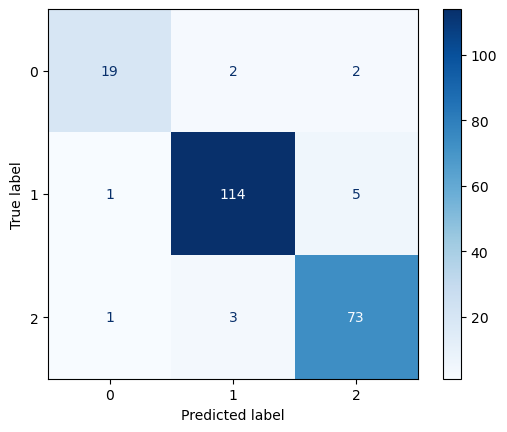

In [54]:
#implement DecisionTRee
from sklearn.tree import DecisionTreeClassifier
#instantiating it to create a DecisionTreeClassifier model:
dtc=DecisionTreeClassifier(criterion='gini')
dtc.fit(X_train,y_train) #train model
y_pred_dtc=dtc.predict(X_test)
y_pred_dtc
# get the accuracy
print(accuracy_score(y_test, y_pred_dtc))
accuracy_score(y_pred_dtc,y_test)
print(classification_report(y_pred_dtc,y_test))

# Calculate the confusion matrix using sklearn.metrics
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_dtc)  # shape=(12, 12)
labels = ['Benign Cases', 'Malignant Cases','Normal']

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

figure = plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues)
plt.show()